In [1]:
import gym

env = gym.make("CartPole-v0")
observation = env.reset()

for i in range(1000):
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)

    if (i+1)%100 == 0:
        print(i+1, observation, reward, done, info)
        
    if done:
        observation = env.reset()

env.close()

100 [-0.0548086   0.39318651 -0.19290797 -1.51309771] 1.0 False {}
200 [ 0.04944493  0.02713672 -0.02309058  0.01835325] 1.0 False {}
300 [ 0.00724534  0.40253073 -0.0315956  -0.53986698] 1.0 False {}
400 [ 0.00558298  0.18719429  0.07341046 -0.01404265] 1.0 False {}
500 [-0.25270156 -1.56090205  0.05184814  1.52180382] 1.0 False {}
600 [-0.01632737  0.58148965  0.00880543 -0.8652589 ] 1.0 False {}
700 [-0.00285941 -0.01946258 -0.06817029 -0.0952997 ] 1.0 False {}
800 [-0.11366835 -0.21743122  0.11695419  0.45095007] 1.0 False {}
900 [-0.0393494   0.23077255  0.10567043  0.04355708] 1.0 False {}
1000 [-0.01648457  0.61288158  0.01374608 -0.85497722] 1.0 False {}


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [4]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(4,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='linear')) # 0 or 1

model.compile(loss='mse', optimizer=RMSprop(lr=0.001)) # lr=0.001 (default)

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [6]:
s = np.array([1,0,1,0])

model.predict(s.reshape(1,4))

array([[-0.27571806, -0.28751948]], dtype=float32)

In [7]:
ws = model.get_weights()

In [8]:
ws[0]

array([[-0.23826581,  0.35165077, -0.365825  , -0.06792012,  0.3650155 ,
        -0.22238731,  0.41860706, -0.24149823,  0.527645  ,  0.41932738,
        -0.23716784, -0.3931693 , -0.39650178,  0.40512025,  0.33194542,
         0.31915754],
       [ 0.45903003, -0.24568841, -0.25287083, -0.05292517, -0.20047936,
        -0.17709172,  0.21853787,  0.30332136, -0.27765092, -0.13428703,
        -0.17099458, -0.36437625, -0.10997406, -0.24482927, -0.4709733 ,
        -0.01303637],
       [ 0.09121442, -0.01243204, -0.52219146,  0.27278394, -0.25647387,
        -0.31761062,  0.03920138,  0.17807871, -0.522805  , -0.14278567,
        -0.06314155,  0.29826063, -0.07930341,  0.28068292, -0.4844106 ,
         0.16633785],
       [ 0.1073879 , -0.0386017 , -0.28884995,  0.00825453,  0.48903704,
         0.33936906, -0.12907726, -0.18355578,  0.14836812,  0.1305657 ,
         0.02387291, -0.39183798,  0.5156621 ,  0.20733583, -0.529648  ,
        -0.28325403]], dtype=float32)

In [9]:
import collections

memory = collections.deque(maxlen = 10000)

In [10]:
s = env.reset()

In [11]:
for i in range(32):
    action = env.action_space.sample() # np.random.randint(2)
    s2, r, done, _ = env.step(action)
    
    memory.append([s, action, r, done, s2])
    
    s = env.reset() if done else s2 # done 이면 리셋

In [12]:
len(memory)

32

In [13]:
display(memory[0], memory[-1])

[array([ 0.02756074, -0.00044016,  0.04895451, -0.0118472 ]),
 1,
 1.0,
 False,
 array([ 0.02755194,  0.19394678,  0.04871757, -0.2886914 ])]

[array([-0.02189662, -0.80403361,  0.05297855,  1.11757253]),
 1,
 1.0,
 False,
 array([-0.03797729, -0.60964538,  0.07533   ,  0.8419677 ])]

In [14]:
epsilon = 1.0 # 처음에는 탐험만 수행한다. (랜덤 행동)
gamma = 0.99 # 감쇠율 (discount factor, 미래 보상을 얼마나 중요시할 지를 결정)
returns = [] # 에피소드 당 총보상값을 저장한다
count = 0

In [15]:
### 총 10000번의 에피소드를 진행한다.
for episode in range(300):
    
    total_reward = 0 # 에피소스당 총보상값
    
    s = env.reset()
    
    for i in range(200): # 한 에피소드당 최대 200번만 행동한다
        
        ### 탐험 확률 지정 (1 부터 시작해서 점점 낮아지다 최소값은 1%)
        epsilon = 0.01 + (1-0.01)*np.exp(-0.0001*count)
        count += 1
        
        if np.random.rand() < epsilon:
            action = env.action_space.sample() # 랜덤 행동
        else:
            action = np.argmax(model.predict(s.reshape(1,4))[0]) # Q값이 높은 행동 선택
            
        s2, r, done, _ = env.step(action)
        
        total_reward += r
        
        memory.append([s, action, r, done, s2])
        
        ### 학습 (배치크기는 32)
        indices = np.random.choice(len(memory), 32, replace=False)
        samples = [memory[i] for i in indices]
        
        X = np.zeros([32,4]) # 입력 상태값
        y = np.zeros([32,2]) # 목표 Q값
        
        for i, sample in enumerate(samples): # sample -> [s,a,r,done,s2]
            X[i] = sample[0]
            y[i] = model.predict(sample[0].reshape(1,4))[0]
            
            if sample[3] == True: # done
                y[i][sample[1]] = sample[2]
            else:
                y[i][sample[1]] = sample[2] + gamma*np.max(model.predict(sample[-1].reshape(1,4))[0])
                
        model.fit(X, y, epochs=1, verbose=False)
        
        if done:
            break
        else:
            s = s2
            
    print('Episode: %d, Reward: %d, Epsilon: %.5f' % (episode+1, total_reward, epsilon))
    returns.append(total_reward)
    
    if total_reward == 200:
        break

Episode: 1, Reward: 30, Epsilon: 0.99713
Episode: 2, Reward: 14, Epsilon: 0.99575
Episode: 3, Reward: 26, Epsilon: 0.99319
Episode: 4, Reward: 11, Epsilon: 0.99211
Episode: 5, Reward: 15, Epsilon: 0.99064
Episode: 6, Reward: 22, Epsilon: 0.98848
Episode: 7, Reward: 10, Epsilon: 0.98751
Episode: 8, Reward: 13, Epsilon: 0.98624
Episode: 9, Reward: 24, Epsilon: 0.98390
Episode: 10, Reward: 50, Epsilon: 0.97904
Episode: 11, Reward: 24, Epsilon: 0.97672
Episode: 12, Reward: 23, Epsilon: 0.97450
Episode: 13, Reward: 31, Epsilon: 0.97151
Episode: 14, Reward: 17, Epsilon: 0.96988
Episode: 15, Reward: 28, Epsilon: 0.96719
Episode: 16, Reward: 22, Epsilon: 0.96509
Episode: 17, Reward: 11, Epsilon: 0.96404
Episode: 18, Reward: 14, Epsilon: 0.96270
Episode: 19, Reward: 16, Epsilon: 0.96118
Episode: 20, Reward: 44, Epsilon: 0.95701
Episode: 21, Reward: 17, Epsilon: 0.95540
Episode: 22, Reward: 49, Epsilon: 0.95078
Episode: 23, Reward: 13, Epsilon: 0.94955
Episode: 24, Reward: 14, Epsilon: 0.94824
E

Episode: 195, Reward: 119, Epsilon: 0.51296
Episode: 196, Reward: 72, Epsilon: 0.50935
Episode: 197, Reward: 111, Epsilon: 0.50384
Episode: 198, Reward: 134, Epsilon: 0.49726
Episode: 199, Reward: 90, Epsilon: 0.49290
Episode: 200, Reward: 164, Epsilon: 0.48504
Episode: 201, Reward: 139, Epsilon: 0.47849
Episode: 202, Reward: 26, Epsilon: 0.47727
Episode: 203, Reward: 95, Epsilon: 0.47285
Episode: 204, Reward: 195, Epsilon: 0.46391
Episode: 205, Reward: 200, Epsilon: 0.45492


In [16]:
len(returns), len(memory)

(205, 8031)

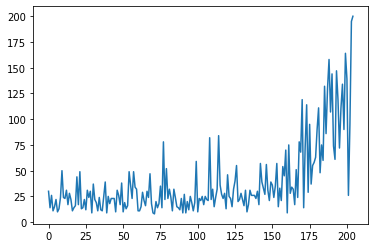

In [17]:
plt.plot(returns)

In [18]:
for epoch in range(3):
    env.reset()
    
    done = False
    n = 0
    while not done:
        #a = np.random.randint(2)
        a = np.argmax(model.predict(s.reshape(1,4))[0])
        s, r, done, info = env.step(a)
        n += 1
        env.render()
        #print(s, r, done, info)
        
    print('Epoch: %d, Count: %d' % (epoch+1, n))
    print(s, r, done, info)
    #input()

Epoch: 1, Count: 150
[2.0504329  2.12909596 0.21258107 0.18507069] 1.0 True {}
Epoch: 2, Count: 158
[2.12959943 2.16991218 0.21370731 0.20810115] 1.0 True {}
Epoch: 3, Count: 157
[2.29500228 2.35241592 0.21183434 0.16074148] 1.0 True {}


In [19]:
env.close()